In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [11]:
'''
Writing a function load_data that loads and preprocess data and splits it randomly
into 70% training, 15% validation and 15% test data
'''

def load_data():

    #load and preprocess real_news and its labels
    realnews_data = open('clean_real.txt')
    realnews = realnews_data.readlines()
    for news in realnews:
        news = news.strip()
    real_labels = []
    for i in range(len(realnews)):
        real_labels.append('Real')
    realnews_data.close()

   #load and preprocess fake_news and its labels
    fakenews_data = open('clean_fake.txt')
    fakenews = fakenews_data.readlines()
    for news in fakenews:
        news = news.strip()
    fake_labels = []
    for i in range(len(fakenews)):
        fake_labels.append('Fake')
    fakenews_data.close()
    
    #Input tranformation using CountVectorizer()
    allnews = realnews + fakenews
    X = vectorizer.fit_transform(allnews)
    X_feature_names = vectorizer.get_feature_names_out().tolist()
    Y = real_labels + fake_labels

    #First splitting the training data randomly into 70% training and 30% non-training sets and then
    # spliiting the 30% non training set into 15% validation and 15% test sets
    X_train, X_nontrain, Y_train, Y_nontrain = train_test_split(X, Y, test_size=0.3, random_state=23)
    X_val, X_test, Y_val, Y_test = train_test_split(X_nontrain, Y_nontrain, test_size=0.5, random_state=23)

    return  X_train, X_val, X_test, Y_train, Y_val, Y_test, X_feature_names

In [12]:
'''
Writing a function select_tree_model that that trains the decision tree
classifier using at least 5 different sensible values of max_depth, as well as two different split
criteria (Information Gain and Gini coefficient), evaluates the performance of each one on
the validation set, and prints the resulting accuracies of each model.
'''
def select_tree_model(X_train, X_val, Y_train, Y_val):
    
    Highest_accuracy = 0
    Best_DT_model = None
    max_depth = [5, 20, 75, 200, 500]
    criterion = ["entropy", "gini"]
    
    for depth in max_depth:
        for criteria in criterion:
            DT_clf = DecisionTreeClassifier(max_depth=depth, criterion=criteria)
            
            # train model on training data
            DT_clf.fit(X_train, Y_train)
            y_val_predict = DT_clf.predict(X_val)
            accuracy = accuracy_score(Y_val, y_val_predict)
            print('\n')
            print(f"For DT split criterion as :{criteria}, and max_depth = {depth}, the accuracy score obtained = {accuracy}")
            if accuracy > Highest_accuracy:
                Highest_accuracy, Best_DT_model = accuracy, DT_clf
                
    print('\n')          
    print("The highest accuracy obtained on validation set is : ", Highest_accuracy)
    print(Best_DT_model, 'criterion =', Best_DT_model.criterion)
    return Best_DT_model

In [17]:
'''
Now let’s stick with the hyperparameters which achieved the
highest validation accuracy. Report its accuracy on the test dataset. Moreover, extract and
visualize the first two layers of the tree.
'''
def plotDecisionTree(model):
    
    plt.figure(figsize=(25,15))
    class_names = model.classes_
    plot = plot_tree(DT_model,max_depth = 2,
                  feature_names=X_feature_names,
                  filled=True, class_names= class_names.tolist(),
                  rounded=True, 
                  fontsize=14)
    return plot

In [18]:
'''
Write a function compute_information_gain which computes the
information gain of a split on the training data. That is, compute I(Y, xi), where Y is the
random variable signifying whether the headline is real or fake, and xi is the keyword chosen
for the split. Your split should be based on whether the keyword xi exists (True) or does
not exist (False). You should ignore the number of times that the keyword appears in the
sentence.
'''
def compute_information_gain(X_train, Y_train, keyword):
    Real_total = 0
    Fake_total = 0
    Total = len(Y_train)
    for n in range(len(Y_train)):
        if Y_train[n] == 'Real':
            Real_total += 1
        else:
            Fake_total += 1
        
    #Entropy at the root
    H_Root = entropy([Real_total,Fake_total], base=2)

    #Splitting the tree into left and right leafs based on whehter the keyword is present or not
    #If the keyword is present, then right leaf;  else right leaf 

    Leftnode_Real = 0
    Leftnode_Fake = 0
    Rightnode_Real = 0
    Rightnode_Fake = 0

    for k in range(len(vectorizer.inverse_transform(X_train))):
        news = vectorizer.inverse_transform(X_train)[k]
        if keyword in news:
            if Y_train[k] == 'Real':
                Rightnode_Real += 1
            else:
                Rightnode_Fake += 1
        else:
            if Y_train[k] == 'Real':
                Leftnode_Real += 1
            else:
                Leftnode_Fake += 1
    
    # Calculating the conditional entropies at the at the left leaf and right leaf of the tree
    H_Leftleaf = entropy([Leftnode_Real, Leftnode_Fake], base=2)
    H_Rightleaf = entropy([Rightnode_Real, Rightnode_Fake], base=2)

    #Information gain = Entropy at root - probaibility(Left Leaf)*(conditional entropy at Left Leaf) - probaibility(Right Leaf)*(conditional entropy at Right Leaf) 
    Information_gain = H_Root - ((float(Leftnode_Fake + Leftnode_Real) / Total) * H_Leftleaf ) - ((float(Rightnode_Real + Rightnode_Fake) / Total) * H_Rightleaf)

    print("The information gain for keyword = ", keyword, ", is", Information_gain)
    print('\n')

    return Information_gain

In [19]:
'''
(KNN) Write a function select_knn_model that uses a KNN classifier to classify
between real vs. fake news. Use a range of k values between 1 to 20 and compute both
training and validation errors.
'''
def select_knn_model(X_train, X_val, Y_train, Y_val):
   
    Highest_accuracy = 0
    Best_k = 0
    Best_KNN_model = None
    K_values = []
    Training_Error = [] 
    Validation_Error = []

    for k in range(1, 21):
        KNN_clf = KNeighborsClassifier(n_neighbors=k)
        KNN_clf.fit(X_train, Y_train)
        K_values.append(k)
        Accuracy_train = KNN_clf.score(X_train, Y_train)           # Training Accuracy
        Training_Error.append(1 - KNN_clf.score(X_train, Y_train)) # Training Error        
        Accuracy_valid = KNN_clf.score(X_val, Y_val)               # Validation Accuracy
        Validation_Error.append(1 - Accuracy_valid)                # Validation Error
        print(f"For K = {k} the accuracy of the KNN classifier for training data is = {Accuracy_train}")
        print(f"For K = {k} the accuracy of the KNN classifier for validation data is = {Accuracy_valid}")
        if Accuracy_valid > Highest_accuracy:
            Highest_accuracy = Accuracy_valid
            Best_KNN_model = KNN_clf
            Best_k = k    
    print(f"The best accuracy achieved on validation data is {Highest_accuracy}, with K = {Best_k}")

    # Required plot of k-values vs training error, validation error
    plt.plot(K_values, Training_Error, label="Training Data", linestyle='-.', color ='blue')
    plt.plot(K_values, Validation_Error, label="Validation Data", linestyle='-.', color ='red')
    plt.legend(loc="lower right")
    plt.xlabel("Value of K")
    plt.ylabel("Error rate")
    plt.show()

    return Best_KNN_model



For DT split criterion as :entropy, and max_depth = 5, the accuracy score obtained = 0.689795918367347


For DT split criterion as :gini, and max_depth = 5, the accuracy score obtained = 0.6918367346938775


For DT split criterion as :entropy, and max_depth = 20, the accuracy score obtained = 0.736734693877551


For DT split criterion as :gini, and max_depth = 20, the accuracy score obtained = 0.7428571428571429


For DT split criterion as :entropy, and max_depth = 75, the accuracy score obtained = 0.7346938775510204


For DT split criterion as :gini, and max_depth = 75, the accuracy score obtained = 0.7306122448979592


For DT split criterion as :entropy, and max_depth = 200, the accuracy score obtained = 0.7326530612244898


For DT split criterion as :gini, and max_depth = 200, the accuracy score obtained = 0.7346938775510204


For DT split criterion as :entropy, and max_depth = 500, the accuracy score obtained = 0.7448979591836735


For DT split criterion as :gini, and max_depth =

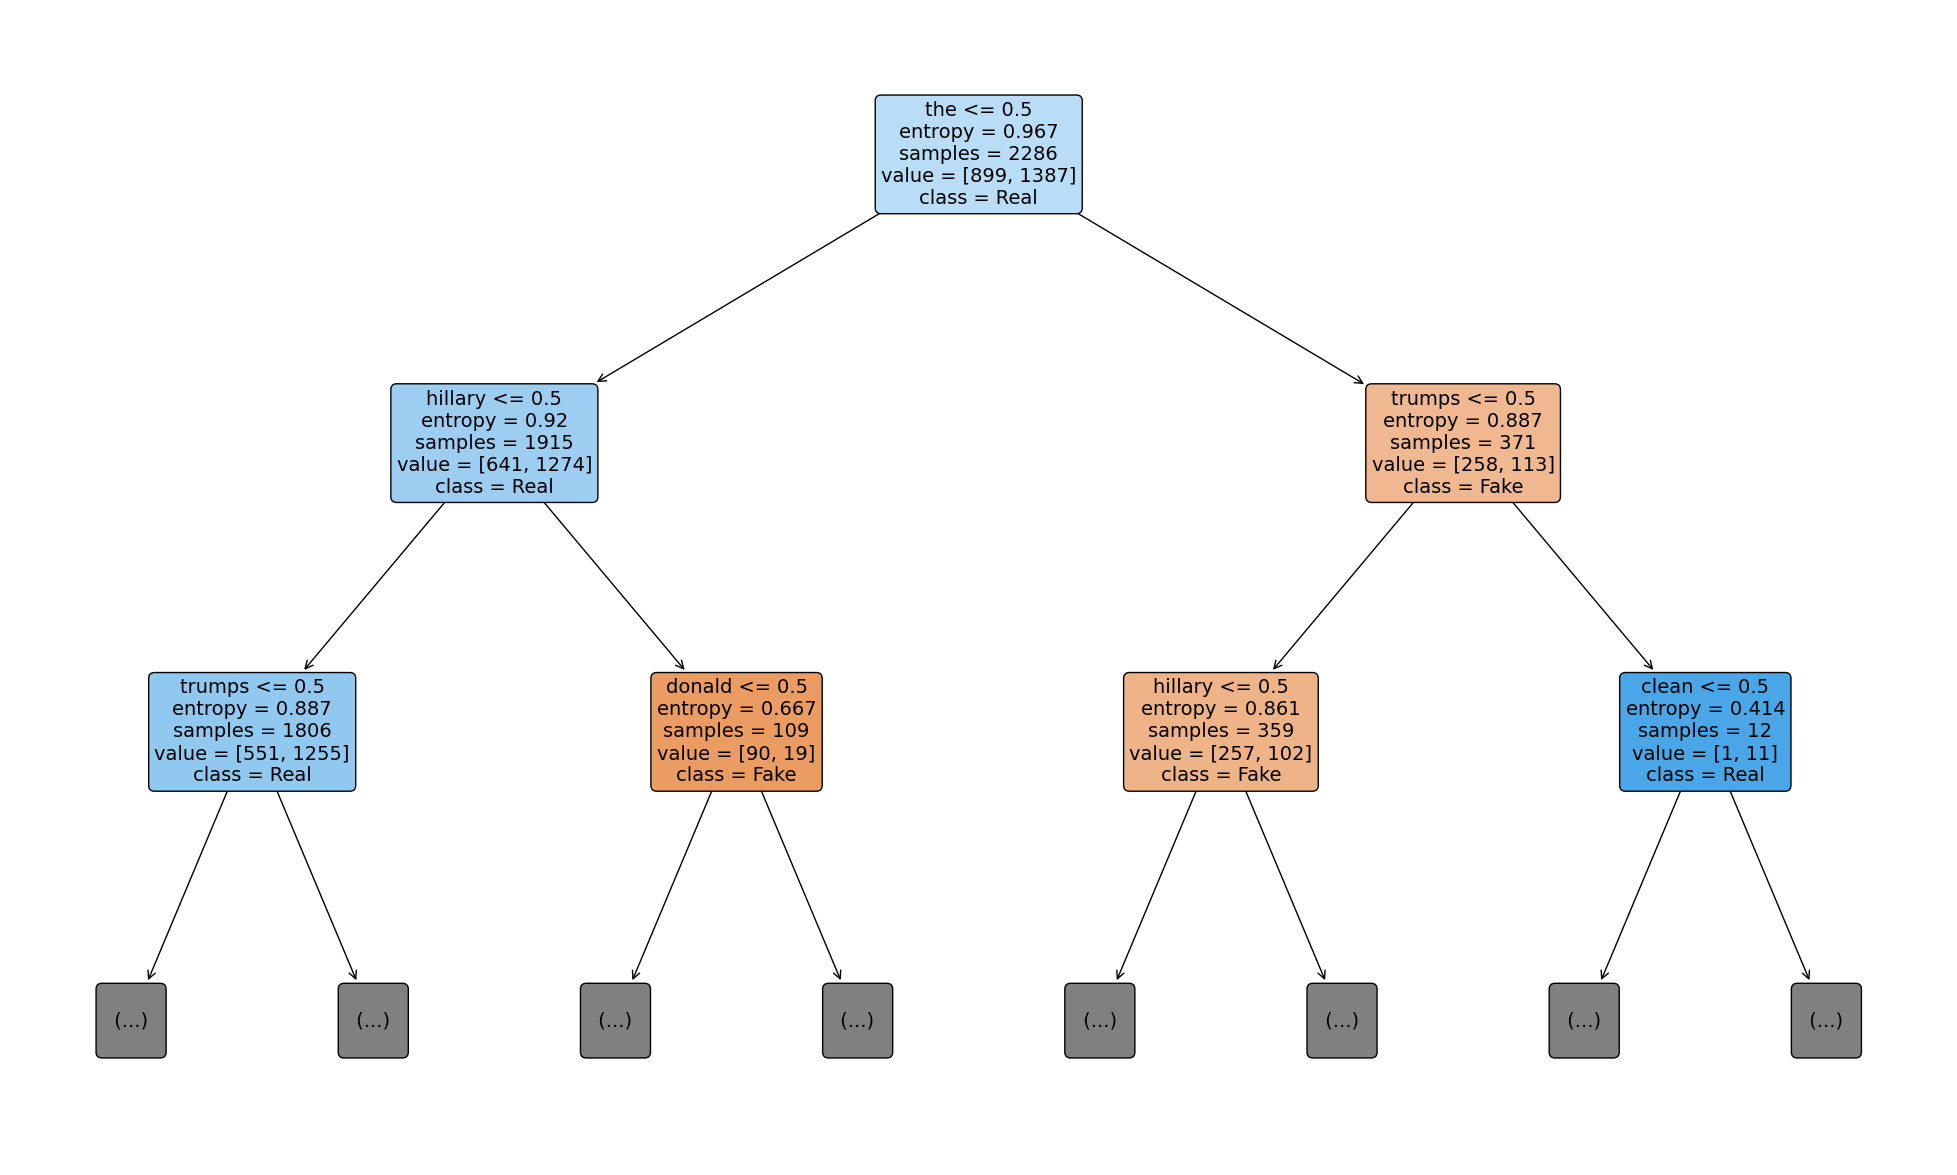

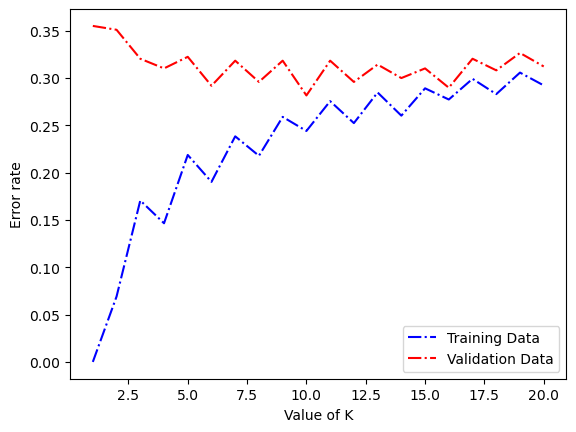

KNeighborsClassifier(n_neighbors=10)
The accuracy of the best KNN on the test dataset is 0.6857142857142857


In [20]:
'''
Main function
'''
if __name__ == "__main__":
    
    #Part A: load_data()
    X_train, X_val, X_test, Y_train, Y_val, Y_test, X_feature_names = load_data()
    
    #Part B: select_tree_model()
    DT_model = select_tree_model(X_train, X_val, Y_train, Y_val)
    print(DT_model)
    y_test_predict = DT_model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_test_predict)
    
    #Part C:Report the best decision tree model accuracy on the test dataset and visualize the first two layers of the tree.
    print('\n')
    print ("The accuracy of the best decision tree model on the test dataset is {}".format(accuracy))
    print('\n')
    plotDecisionTree(DT_model)
    
    #Part D:compute_information_gain()
    keywords = ['the', 'hilary', 'trumps','donald','clinton',]
    #for keyword in keywords:
        #compute_information_gain(X_train, Y_train, keyword)
        
    #Part E: select_knn_model()
    plt.figure() 
    KNN_model = select_knn_model(X_train, X_val, Y_train, Y_val)   
    plt.show()    
    print(KNN_model)
    y_test_predict = KNN_model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_test_predict)
    print ("The accuracy of the best KNN on the test dataset is {}".format(accuracy))
